In [ ]:
# LSTM Model
# Anushka Chokshi (015587884) & Aditi Jorapur (015617225)
!pip install scikit-plot
!pip install imbalanced-learn

#import libraries

import nltk
import keras
import string
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import scikitplot as skplt

#download NLTK data

nltk.download('stopwords')
nltk.download('punkt')

from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Function to preprocess the data

def preprocess(file):

    #remove punctuation from the input
    file = file.translate(str.maketrans('', '', string.punctuation))
    #split the input into tokens
    tokenize = file.split();
    #get the set of english stop words
    all_stop_words = set(stopwords.words('english'))
    #remove all stop words from the input data
    tokens = [word for word in tokenize if word not in all_stop_words]
    #join the tokens together into a single string
    final_text = ' '.join(tokenize)
    return final_text

#load the train, test, and validation data and applying preprocessing to the datasets
train = pd.read_csv('train.csv', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
train['Input'] = train['Input'].apply(preprocess)

test = pd.read_csv('test.csv', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
test['Input'] = test['Input'].apply(preprocess)

validation = pd.read_csv('validation.csv', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
validation['Input'] = validation['Input'].apply(preprocess)


#vectorization for converting the words in the input data to sequences od integers
vectorize = tf.keras.layers.TextVectorization(max_tokens=15212, output_mode='int', output_sequence_length=80)
vectorize.adapt(train['Input'].values)

#apply vecotrization to the train data
X_train = vectorize(train['Input'].values)
X_test = vectorize(test['Input'].values)
X_validation = vectorize(validation['Input'].values)

#apply oversampling to handle imbalanced data
smote_technique = SMOTE(random_state=42)
X_train_res, y_train_res = smote_technique.fit_resample(X_train, train['Sentiment'])


In [ ]:
#initialize the tokenizer to a vocab size of 15,212, convert all data to lowercase, replace non-vocab words with token
token = Tokenizer(15212,lower=True,oov_token='UNK')
#get the input values
X = train['Input'].values
#apply the tokenizer on the values
token.fit_on_texts(X)
#convert the train data into a sequence of integets
X_train = token.texts_to_sequences(X)
#add padding to ensure they add have the same length
X_train_with_pad = pad_sequences(X_train,maxlen=80,padding='post')
#map the sentiment labels to numerical values (0-5)
train['Sentiment']= train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
#get the sentiment values and perform one-hot encoding
Y_train= train['Sentiment'].values
Y_train_convert = to_categorical(Y_train)
#Y_train_convert[:10]
#get the input from the validation data and perform the same steps as above but on the validation data
X_validation = validation['Input']
Y_validation = validation.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
X_validation_function =token.texts_to_sequences(X_validation)
X_validation_padding = pad_sequences(X_validation_function,maxlen=80,padding='post')

Y_validation_function=to_categorical(Y_validation)
#Y_validation_function[:10]

In [ ]:
#initialize the sequential model
model = Sequential()
#add the embedding layer: fixed sizes: 64, vocab size is 15,212 and input length is 80
model.add(Embedding(15212,64,input_length=80))
#to prevent overfitting added a dropout layer (60% will be dropped during training)
model.add(Dropout(0.6))
#add bidrectional layer with 80 units
model.add(Bidirectional(LSTM(80,return_sequences=True)))
#add bidirectional layer with 160 units
model.add(Bidirectional(LSTM(160)))
#add dense layer with softmax as the activation function for the output
model.add(Dense(6,activation='softmax'))

#compile the model using adam as the optimizer and categorical cross-entropy as the loss function
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#train the model using 12 epochs
hist=model.fit(X_train_with_pad,Y_train_convert,epochs=12,validation_data=(X_validation_padding,Y_validation_function))

Epoch 1/12
500/500 [==============================] - 35s 56ms/step - loss: 1.2422 - accuracy: 0.5199 - val_loss: 0.7728 - val_accuracy: 0.7165
Epoch 2/12
500/500 [==============================] - 10s 19ms/step - loss: 0.5537 - accuracy: 0.8033 - val_loss: 0.3163 - val_accuracy: 0.8910
Epoch 3/12
500/500 [==============================] - 9s 18ms/step - loss: 0.2935 - accuracy: 0.9022 - val_loss: 0.2800 - val_accuracy: 0.9035
Epoch 4/12
500/500 [==============================] - 8s 16ms/step - loss: 0.2077 - accuracy: 0.9263 - val_loss: 0.2318 - val_accuracy: 0.9200
Epoch 5/12
500/500 [==============================] - 9s 18ms/step - loss: 0.1611 - accuracy: 0.9413 - val_loss: 0.2065 - val_accuracy: 0.9220
Epoch 6/12
500/500 [==============================] - 8s 17ms/step - loss: 0.1358 - accuracy: 0.9506 - val_loss: 0.1860 - val_accuracy: 0.9285
Epoch 7/12
500/500 [==============================] - 8s 16ms/step - loss: 0.1150 - accuracy: 0.9588 - val_loss: 0.1884 - val_accuracy: 0.92

500/500 [==============================] - 4s 6ms/step


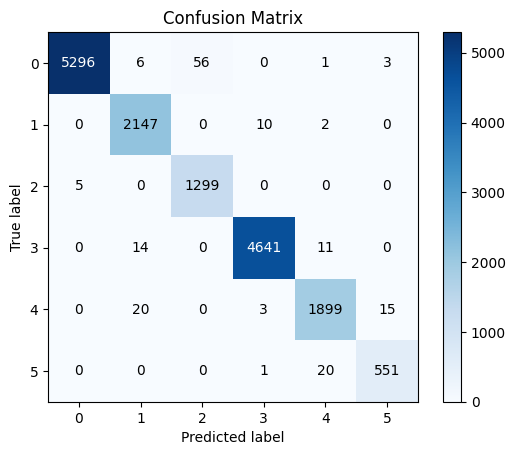

In [ ]:
#predict the probabilities for the training data
Y_train_prediction_probability = model.predict(X_train_with_pad)
Y_train_prediction_classes = np.argmax(Y_train_prediction_probability, axis=1)
#get the actual labels for the classes
Y_train_actual_classes = np.argmax(Y_train_convert, axis=1)
#display the confusion matrix to visualize the training data metrics
plot_confusion_matrix(Y_train_actual_classes, Y_train_prediction_classes, normalize=False)
plt.show()


In [ ]:
#predict the probabilities for the training data
Y_train_prediction_probs = model.predict(X_train_with_pad)
Y_train_prediction = np.argmax(Y_train_prediction_probs, axis=1)
#compute the accuracy of the training data
accuracy_metric = accuracy_score(Y_train, Y_train_prediction)
print("Train Accuracy:", accuracy_metric)
#compute the precision of the training data
precision_metric = precision_score(Y_train, Y_train_prediction, average='weighted')
print("Train Precision:", precision_metric)
#compute the recall of the training data
recall_metric = recall_score(Y_train, Y_train_prediction, average='weighted')
print("Train Recall:", recall_metric)
#compute the f1-score of the training data
f1_metric = f1_score(Y_train, Y_train_prediction, average='weighted')
print("Train F1-Score:", f1_metric)


500/500 [==============================] - 3s 6ms/step
Train Accuracy: 0.9895625
Train Precision: 0.9897102491759288
Train Recall: 0.9895625
Train F1-Score: 0.9895898704129883


In [ ]:
#validation set predictions
Y_validation_prediction_probs = model.predict(X_validation_padding)
Y_validation_prediction = np.argmax(Y_validation_prediction_probs, axis=1)
#compute the accuracy of the validaiton data
accuracy_metric_validation = accuracy_score(Y_validation, Y_validation_prediction)
print("Validation Accuracy:", accuracy_metric_validation)
#compute the precision of the validaiton data
precision_metric_validation = precision_score(Y_validation, Y_validation_prediction, average='weighted')
print("Validation Precision:", precision_metric_validation)
#compute the recall of the validaiton data
recall_metric_validation = recall_score(Y_validation, Y_validation_prediction, average='weighted')
print("Validation Recall:", recall_metric_validation)
#compute the f1-score of the validaiton data
f1_metric_validation = f1_score(Y_validation, Y_validation_prediction, average='weighted')
print("Validation F1-Score:", f1_metric_validation)


63/63 [==============================] - 2s 6ms/step
Validation Accuracy: 0.936
Validation Precision: 0.9369314458070275
Validation Recall: 0.936
Validation F1-Score: 0.936088497615152


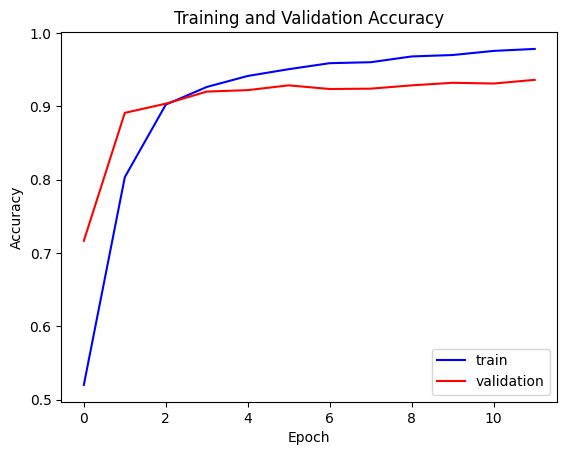

In [ ]:
# Plotting the training and validation accuracy over epochs
plt.plot(hist.history['accuracy'], c='b', label='train')
plt.plot(hist.history['val_accuracy'], c='r', label='validation')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

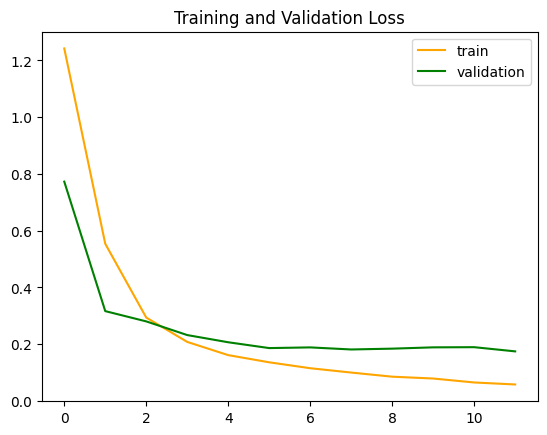

In [ ]:
# Plotting the training and validation loss over epochs
plt.plot(hist.history['loss'],c='orange',label='train')
plt.plot(hist.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Preprocessing the test data
#get the data from test
X_testing=test['Input']
#replace sentiments with numeric values
Y_testing=test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
#convert to sequences
X_test_f=token.texts_to_sequences(X_testing)
#add padding to the test data
X_test_padding=pad_sequences(X_test_f,maxlen=80,padding='post')
#convert to one hot encoded
Y_test_f=to_categorical(Y_testing)
#show the shape
X_test_padding.shape

#Y_test_f[:7]
#evaluate the model on test data
model.evaluate(X_test_padding,Y_test_f)
#predict the probabilities
Y_pred_probability = model.predict(X_test_padding)
#convert to the class predictions
Y_predictions = np.argmax(Y_pred_probability, axis=1)

63/63 [==============================] - 0s 6ms/step


63/63 [==============================] - 0s 6ms/step


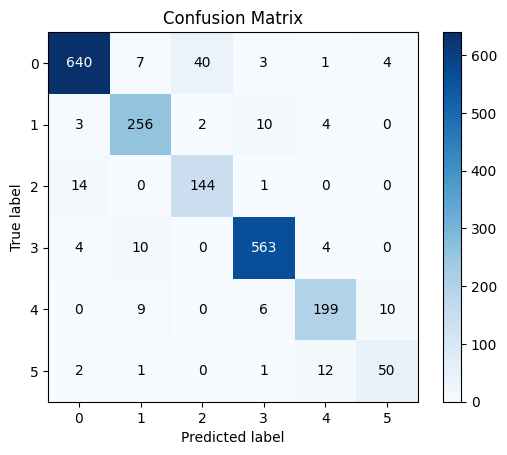

In [ ]:
# predict on the test set
Y_test_prediction_probability = model.predict(X_test_padding)
Y_test_prediction_classes = np.argmax(Y_test_prediction_probability, axis=1)
#get class labels from one hot encoded
Y_test_actual_classes = np.argmax(Y_test_f, axis=1)

#confusion matrix for test
plot_confusion_matrix(Y_test_actual_classes, Y_test_prediction_classes, normalize=False)
plt.show()


In [ ]:
#labls for testing and validation sets
# Predictions on the test set
Y_test_prediction_probs = model.predict(X_test_padding)
Y_test_prediction = np.argmax(Y_test_prediction_probs, axis=1)
#calculate accuracy for test data
accuracy_metric_test = accuracy_score(Y_testing, Y_test_prediction)
print("Test Accuracy:", accuracy_metric_test)
#calculate precision for test data
precision_metric_test = precision_score(Y_testing, Y_test_prediction, average='weighted')
print("Test Precision:", precision_metric_test)
#calculate recall for test data
recall_metric_test = recall_score(Y_testing, Y_test_prediction, average='weighted')
print("Test Recall:", recall_metric_test)
#calculate f1-score for test data
f1_metric_test = f1_score(Y_testing, Y_test_prediction, average='weighted')
print("Test F1-Score:", f1_metric_test)


63/63 [==============================] - 0s 6ms/step
Test Accuracy: 0.926
Test Precision: 0.9285192390133786
Test Recall: 0.926
Test F1-Score: 0.9266267117568018


In [ ]:
#method to define the numeric label mappings
def get_key(numeric_label):
    sentiment_mapping = {'joy': 0, 'anger': 1, 'love': 2, 'sadness': 3, 'fear': 4, 'surprise': 5}
    for sentiment, label in sentiment_mapping.items():
        if label == numeric_label:
          #return the correct sentiment
            return sentiment

In [ ]:
#method to predict the sentiment given the input sentence
def predict(text):
    #convert input text to list
    text_lst = [text]
    #convert to sequences of integers
    text_seq = token.texts_to_sequences(text_lst)
    #pad the sequences
    text_padded = pad_sequences(text_seq, maxlen=80, padding='post')
    #index class with the highest probability
    predictions = model.predict(text_padded)
    predicted_class_index = np.argmax(predictions)
    # Get the predicted emotion label corresponding to the class index
    predicted_emotion = get_key(predicted_class_index)
    #print the emotions
    print("The emotion predicted is:", predicted_emotion)

In [ ]:
#user can enter a sentence and predict the emotion
predict(str(input('Enter a sentence : ')))

Enter a sentence : Life is good!
1/1 [==============================] - 0s 26ms/step
The emotion predicted is: joy
